---
title: Ridge and LASSO Regularization
---

In the last lecture, we started discussing nonlinear regression models. As a motivating example, we considered the following dataset (from FRED) on Annual Estimates of the Resident Population of California (units are thousands of persons) from 1900 to 2024. 

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

  observation_date   CAPOP
0       1900-01-01  1490.0
1       1901-01-01  1550.0
2       1902-01-01  1623.0
3       1903-01-01  1702.0
4       1904-01-01  1792.0
5       1905-01-01  1893.0
6       1906-01-01  1976.0
7       1907-01-01  2054.0
8       1908-01-01  2161.0
9       1909-01-01  2282.0
    observation_date      CAPOP
115       2015-01-01  38904.296
116       2016-01-01  39149.186
117       2017-01-01  39337.785
118       2018-01-01  39437.463
119       2019-01-01  39437.610
120       2020-01-01  39521.958
121       2021-01-01  39142.565
122       2022-01-01  39142.414
123       2023-01-01  39198.693
124       2024-01-01  39431.263


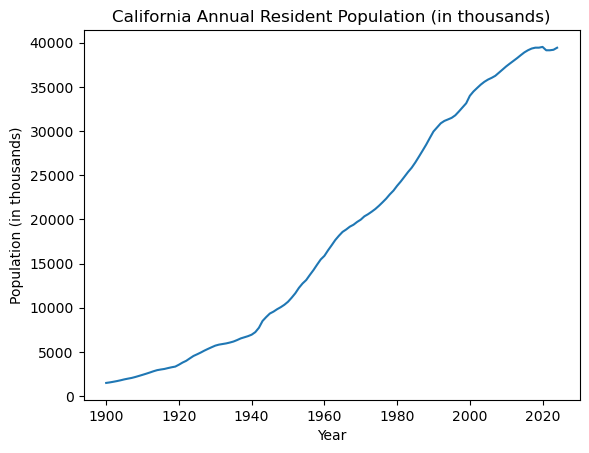

In [169]:
capop = pd.read_csv('CAPOP_11Sept2025.csv')
print(capop.head(10))
print(capop.tail(10))
tme = np.arange(1900, 2025)
plt.plot(tme, capop['CAPOP'], label='California Population')
plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('California Annual Resident Population (in thousands)')
plt.show()

We work with the logarithms of the population data as this will lead to models with better interpretability. 

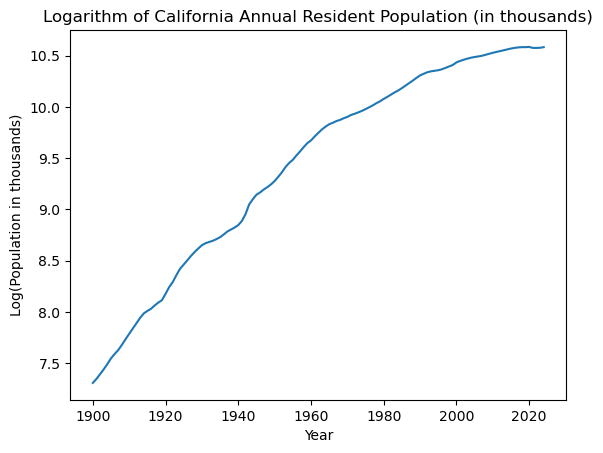

In [170]:
y = np.log(capop['CAPOP'])
n = len(y)
plt.plot(tme, y)
plt.xlabel('Year')
plt.ylabel('Log(Population in thousands)')
plt.title('Logarithm of California Annual Resident Population (in thousands)')
plt.show()

We shall fit the following model to this dataset:
\begin{equation*}
  y_t = \beta_0 + \beta_1 (t - 1) + \beta_2 (t - 2)_+ + \beta_3 (t - 3)_+ + \dots + \beta_{n-1} (t - (n-1))_+ + \epsilon_t
\end{equation*}
We can write this as
\begin{equation*}
   y = X_{\text{full}} \beta + \epsilon
\end{equation*}
where $X_{\text{full}}$ is constructed as below. 

In [171]:
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 122. 121. ...   1.   0.  -0.]
 [  1. 123. 122. ...   2.   1.   0.]
 [  1. 124. 123. ...   3.   2.   1.]]


If we fit this model without any regularization, we get the following. 

In [172]:
mdfull = sm.OLS(y, Xfull).fit()
print(mdfull.summary())

                            OLS Regression Results                            
Dep. Variable:                  CAPOP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 02 Oct 2025   Prob (F-statistic):                nan
Time:                        16:09:30   Log-Likelihood:                 3409.6
No. Observations:                 125   AIC:                            -6569.
Df Residuals:                       0   BIC:                            -6216.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3065        inf          0        n

/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In this unregularized estimation, the estimate of $\beta_0$ equals $y_1$, the estimate of $\beta_1$ is $y_2 - y_1$, and the estimate of $\beta_j$ is $y_{j+1} - 2 y_j + y_{j-1}$ for $j = 2, \dots, n-1$. Let us check this. 

In [173]:
print(y[0], mdfull.params.iloc[0])
print(y[1] - y[0], mdfull.params.iloc[1])
print(y[2] - y[1] - y[1] + y[0], mdfull.params.iloc[2])
print(y[3] - y[2] - y[2] + y[1], mdfull.params.iloc[3])
print(y[4] - y[3] - y[3] + y[2], mdfull.params.iloc[4])

7.306531398939505 7.3065313989395415
0.03947881097378758 0.03947881097376421
0.006542546627510859 0.00654254662755926
0.0015063840174303067 0.001506384017439581
0.004000542782827132 0.0040005427827803555


## Ridge and LASSO regularized estimation

We now compute the ridge and lasso regularized estimators using the optimization library `cvxpy`. `cvxpy` is a library for formulating and solving convex optimization problems. It is widely used in Machine Learning, Statistics, Engineering etc. 

In [174]:
import cvxpy as cp

Here is the function for solving the ridge optimization problem. Given $y_{n \times 1}$, $X_{n  \times m}$ and $\lambda$, this code solves the problem: 
\begin{align*}
    \text{Minimize} ~ \left[\|y - X \beta\|^2 + \lambda (\beta_s^2 + \dots + \beta_m^2) \right]
\end{align*}
Here $s$ denotes `penalty_start` in the code (the penalty does not involve $\beta_j$ for $j < s$). 


In [175]:
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value


Below is the code for computing the ridge estimator with a fixed value of $\lambda$. We also plot the fitted values (these are the values $\hat{\mu}^{\text{ridge}}(\lambda) = X \hat{\beta}^{\text{ridge}}(\lambda)$) corresponding to the Ridge estimate. 

Play around with  different values of $\lambda$ and see how the estimator changes. 

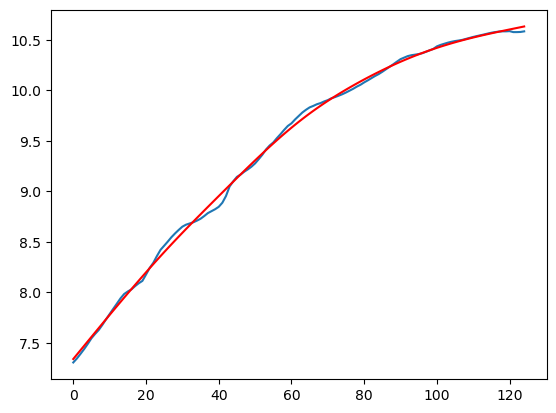

In [196]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 10000) #lambda = 10000 seems to work well
#print(b_ridge)
plt.plot(y)
ridge_fitted = np.dot(Xfull, b_ridge)
plt.plot(ridge_fitted, color = 'red')
plt.show()

Here is the function for minimizing the LASSO objective function. Given $y_{n \times 1}$, $X_{n  \times m}$ and $\lambda$, this code solves the problem: 
\begin{align*}
    \text{Minimize} ~ \left[\|y - X \beta\|^2 + \lambda (|\beta_s| + \dots + |\beta_m|) \right]
\end{align*}
Here $s$ denotes `penalty_start` in the code (the penalty does not involve $\beta_j$ for $j < s$). 


In [185]:
def solve_lasso(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value


Below is the code for computing the ridge estimator with a fixed value of $\lambda$. We also plot the fitted values (these are the values $\hat{\mu}^{\text{lasso}}(\lambda) = X \hat{\beta}^{\text{lasso}}(\lambda)$) corresponding to the Ridge estimate. 

Play around with  different values of $\lambda$ and see how the estimator changes. 

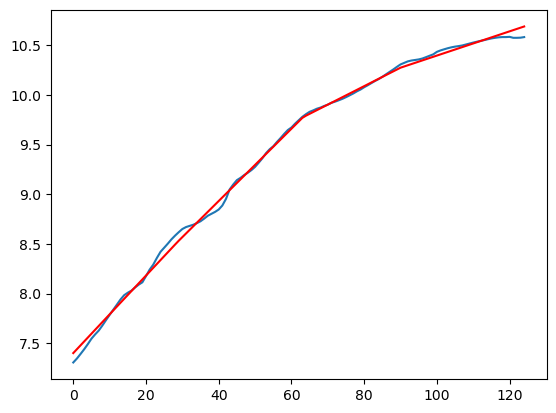

In [191]:
b_lasso = solve_lasso(Xfull, y, lambda_val = 25) #10 seems to work well
#print(b_lasso)
plt.plot(y)
lasso_fitted = np.dot(Xfull, b_lasso)
plt.plot(lasso_fitted, color = 'red')
plt.show()

The LASSO estimator is typically sparse. This can be checked by the code below where we only display the estimated coefficients which cross a threshold in absolute value. 

In [194]:
threshold = 1e-6
significant_idx = np.where(np.abs(b_lasso) > threshold)[0]
print(b_lasso[significant_idx])
# Or to see index-value pairs:
for idx in significant_idx:
    print(f"Index {idx}: {b_lasso[idx]}")

[ 7.40101781e+00  3.90266732e-02 -6.92496253e-04 -1.95497046e-03
 -1.41763312e-02 -3.62292248e-03 -6.37795834e-03]
Index 0: 7.401017811074355
Index 1: 0.03902667316754264
Index 29: -0.0006924962529493638
Index 30: -0.001954970458737117
Index 64: -0.01417633117574186
Index 65: -0.003622922481167155
Index 91: -0.006377958342345468


Below we plot both the ridge and LASSO fits.

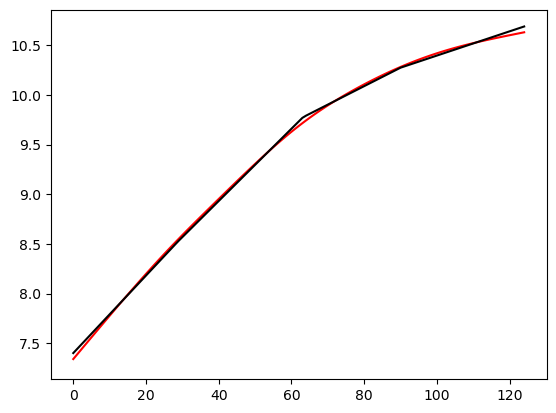

In [197]:
plt.plot(y, color = 'None')
ridge_fitted = np.dot(Xfull, b_ridge)
plt.plot(ridge_fitted, color = 'red')
lasso_fitted = np.dot(Xfull, b_lasso)
plt.plot(lasso_fitted, color = 'black')
plt.show()

The two fitted values seem quite similar.

## Fitting Smooth Trend Functions to Data

These models and the corresponding Ridge and LASSO estimators are useful for fitting trend functions to data. 

The following two datasets are from [NOAA climate at a glance](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/tavg/land_ocean/1/1/1850-2025). They contain temperature anomalies for the months of January and June (for each year from 1850 to 2025). Anomalies are in celsius and are with respect to the 1901-2000 average. 

     Year  Anomaly
0    1850    -0.46
1    1851    -0.17
2    1852    -0.02
3    1853    -0.12
4    1854    -0.28
..    ...      ...
171  2021     0.83
172  2022     0.92
173  2023     0.89
174  2024     1.30
175  2025     1.33

[176 rows x 2 columns]


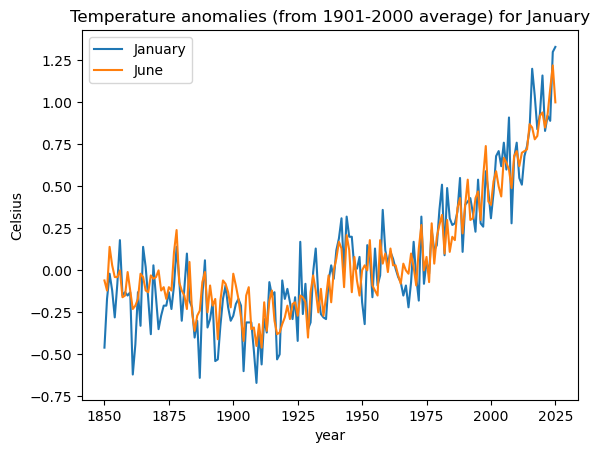

In [199]:
temp_jan = pd.read_csv('TempAnomalies_January.csv', skiprows=4)
temp_june = pd.read_csv('TempAnomalies_June.csv', skiprows=3)
print(temp_jan)
y_jan = temp_jan['Anomaly']
y_june = temp_june['Anomaly']
plt.plot(temp_jan['Year'], y_jan, label='January')
plt.plot(temp_jan['Year'], y_june, label='June')
plt.legend()
plt.xlabel('year')
plt.ylabel('Celsius')
plt.title('Temperature anomalies (from 1901-2000 average) for January')
plt.show()

We shall fit a trend function to each of these two datasets. The first step is to create the $X$ matrix. 

In [200]:
n = len(y_jan) #both datasets have the same length, so the X matrix will be the same for both
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 173. 172. ...   1.   0.  -0.]
 [  1. 174. 173. ...   2.   1.   0.]
 [  1. 175. 174. ...   3.   2.   1.]]


The ridge regression estimate is computed below. Start with some standard choice of $\lambda$ (e.g., $\lambda = 1$) and then increase or decrease it by factors of 10 until you get a fit that is visually nice (smooth while capturing patterns in the data).

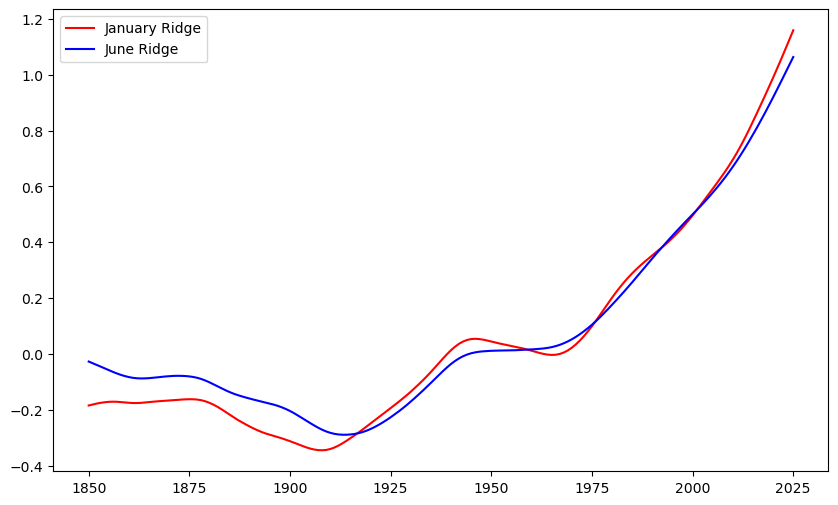

In [201]:
b_ridge_jan = solve_ridge(Xfull, y_jan, lambda_val = 1000)
ridge_fitted_jan = np.dot(Xfull, b_ridge_jan)

b_ridge_june = solve_ridge(Xfull, y_june, lambda_val = 1000)
ridge_fitted_june = np.dot(Xfull, b_ridge_june)

plt.figure(figsize = (10, 6))
#plt.plot(temp_jan['Year'], y_jan, color = 'lightgray')
plt.plot(temp_jan['Year'], ridge_fitted_jan, color = 'red', label = 'January Ridge')
plt.plot(temp_jan['Year'], ridge_fitted_june, color = 'blue', label = 'June Ridge')
plt.legend()
plt.show()

We repeat the exercise with LASSO below. 

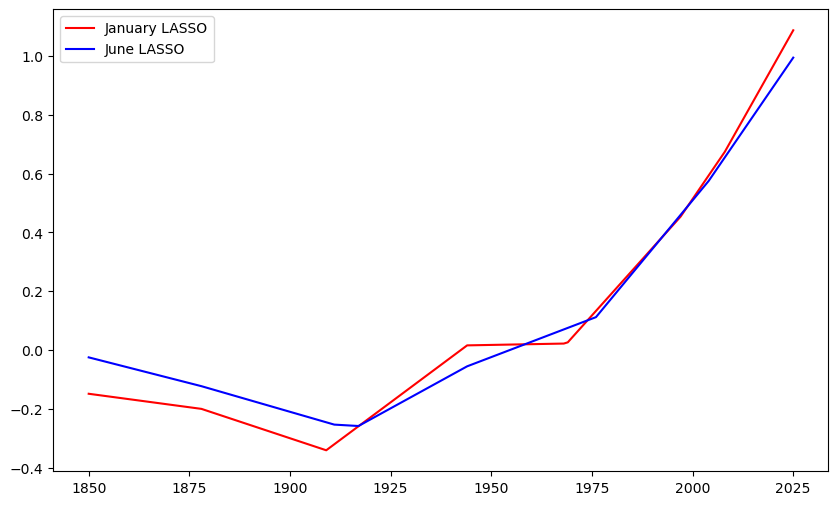

In [202]:
b_lasso_jan = solve_lasso(Xfull, y_jan, lambda_val = 10)
lasso_fitted_jan = np.dot(Xfull, b_lasso_jan)

b_lasso_june = solve_lasso(Xfull, y_june, lambda_val = 10)
lasso_fitted_june = np.dot(Xfull, b_lasso_june)

plt.figure(figsize = (10, 6))
#plt.plot(temp_jan['Year'], y, color = 'lightgray')
plt.plot(temp_jan['Year'], lasso_fitted_jan, color = 'red', label = 'January LASSO')
plt.plot(temp_jan['Year'], lasso_fitted_june, color = 'blue', label = 'June LASSO')    
plt.legend()
plt.show()

## Cross-validation for picking $\lambda$

In [203]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    k = 5
    fold_size = n // k
    folds = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else n  # last fold includes remainder
        test_indices = np.arange(start, end)
        train_indices = np.concatenate([np.arange(0, start), np.arange(end, n)])
        folds.append((train_indices, test_indices))

    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val=lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)

    for lamb in lambda_candidates:
        cv_errors[lamb] /= n

    best_lambda = min(cv_errors, key=cv_errors.get)
    return best_lambda, cv_errors


In [204]:
y = y_jan
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])

best_lambda, cv_errors = ridge_cv(Xfull, y, lambda_candidates)
print(best_lambda)
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


1000.0
Lambda = 0.10, CV Error = 11.850955
Lambda = 1.00, CV Error = 2.261767
Lambda = 10.00, CV Error = 0.513626
Lambda = 100.00, CV Error = 0.126082
Lambda = 1000.00, CV Error = 0.044625
Lambda = 10000.00, CV Error = 0.048169
Lambda = 100000.00, CV Error = 0.073446


In [205]:
def lasso_cv(X, y, lambda_candidates):
    n = len(y)
    k = 5
    fold_size = n // k
    folds = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else n  # last fold includes remainder
        test_indices = np.arange(start, end)
        train_indices = np.concatenate([np.arange(0, start), np.arange(end, n)])
        folds.append((train_indices, test_indices))

    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_lasso(X_train, y_train, lambda_val=lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)

    for lamb in lambda_candidates:
        cv_errors[lamb] /= n

    best_lambda = min(cv_errors, key=cv_errors.get)
    return best_lambda, cv_errors


In [206]:
y = y_june
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
best_lambda, cv_errors = lasso_cv(Xfull, y, lambda_candidates)
print(best_lambda)
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


10.0
Lambda = 0.10, CV Error = 1.907423
Lambda = 1.00, CV Error = 0.072098
Lambda = 10.00, CV Error = 0.038189
Lambda = 100.00, CV Error = 0.078824
Lambda = 1000.00, CV Error = 0.165582
Lambda = 10000.00, CV Error = 0.165582
Lambda = 100000.00, CV Error = 0.165582


## Shrinkage and Sparsity

Let us compare the ridge regularized estimates of $\beta$ with the unregularized estimates (unregularized means $\lambda = 0$).

0.28999999999997206 0.003551957730090027
-0.4599999999999922 -0.18495721415398625


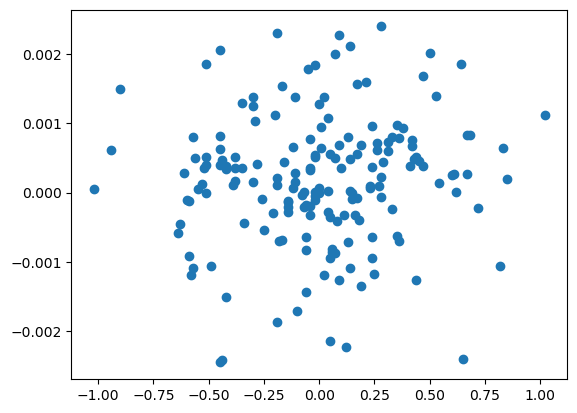

In [207]:
y = y_jan
b_ridge_0 = solve_ridge(Xfull, y, lambda_val = 0)
b_ridge = solve_ridge(Xfull, y, lambda_val = 1000)
plt.scatter(b_ridge_0[2:], b_ridge[2:])
print(b_ridge_0[1], b_ridge[1])
print(b_ridge_0[0], b_ridge[0])

Note that the $y$-axis above has a much tighter range compared to the $x$-axis. This illustrates the **shrinkage** aspect of ridge regression. It shrinks the unregularized estimates towards zero. 

0.290000000008449 -0.00183578311693186
-0.46000000053282925 -0.14899519332692354


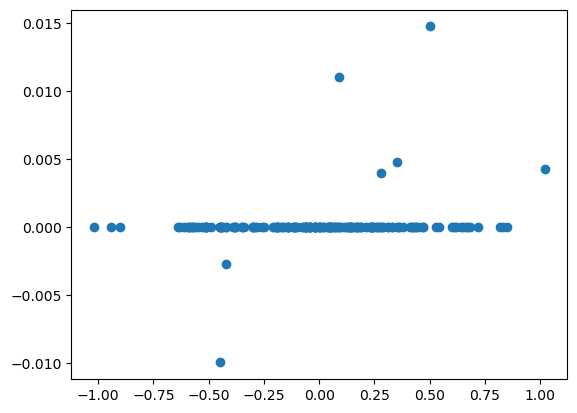

In [208]:
y = y_jan
b_lasso_0 = solve_lasso(Xfull, y, lambda_val = 0)
b_lasso = solve_lasso(Xfull, y, lambda_val = 10)
plt.scatter(b_lasso_0[2:], b_lasso[2:])
print(b_lasso_0[1], b_lasso[1])
print(b_lasso_0[0], b_lasso[0])

This plot clearly shows that the LASSO sets most coefficients exactly to zero. Compare this plot to the corresponding plot for the ridge estimator. This means that LASSO is setting most of the $\beta_j$'s to zero. This is referred to as **sparsity**. 

Ridge estimation results in shrinkage and LASSO estimation results in sparsity. 

## Simulated Data

I am simulating two time series datasets (of the same size $n = 1000$) using the code below. 

In [209]:
def smoothfun(x):
    ans = np.sin(15*x) + 3*np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 5 * np.log(x + 0.1) + 7
    return ans

n = 1000
xx = np.linspace(0, 1, n)
truth_1 = np.array([smoothfun(x) for x in xx])

sig_1 = 2
rng = np.random.default_rng(seed = 42)
errorsamples_1 = rng.normal(loc=0, scale = sig_1, size = n)
y_1 = truth_1 + errorsamples_1


xx = np.linspace(0, 1, n)
truth_2 = 0.8*truth_1

sig_2 = 3
errorsamples_2 = rng.normal(loc=0, scale = sig_2, size = n)
y_2 = truth_2 + errorsamples_2

Here are the two datasets plotted.

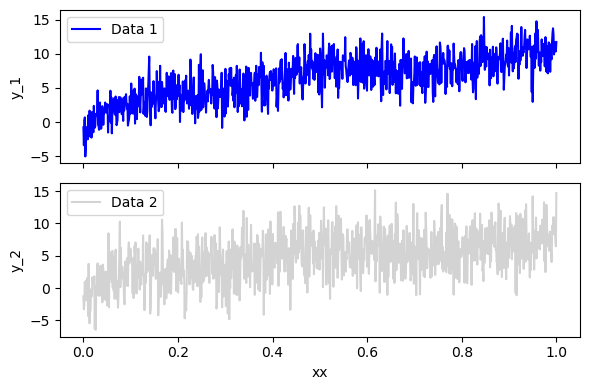

In [210]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# First panel
axes[0].plot(xx, y_1, label='Data 1', color='blue')
axes[0].legend()
axes[0].set_ylabel("y_1")

# Second panel
axes[1].plot(xx, y_2, label='Data 2', color='lightgray')
axes[1].legend()
axes[1].set_xlabel("xx")
axes[1].set_ylabel("y_2")

plt.tight_layout()
plt.show()


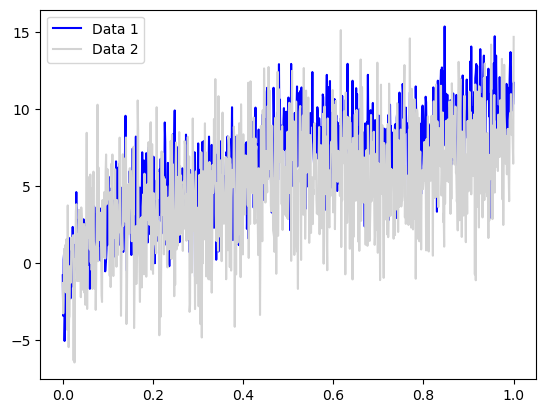

In [211]:
#Plotting both datasets together:
plt.plot(xx, y_1, label = 'Data 1', color = 'blue')
plt.plot(xx, y_2, label = 'Data 2', color = 'lightgray')
plt.legend()
plt.show()

Each of these datasets is generated by taking a smooth function, and adding noise to it. The smooth functions which generated the data are shown below. 

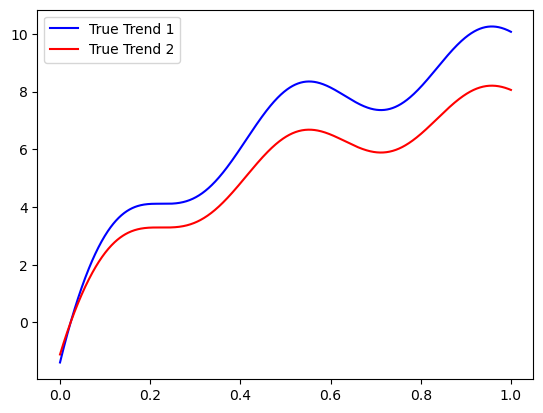

In [212]:
#True functions which generated the data:
plt.plot(xx, truth_1, label = 'True Trend 1', color = 'blue')
plt.plot(xx, truth_2, label = 'True Trend 2', color = 'red')
plt.legend()
plt.show()


These smooth functions (which generated the data) are clearly different. These differences are not easy to see however when we look at the raw data directly because of noise. We can use our trend estimates (based on ridge and lasso) to denoise the data so that they become comparable. 

In [213]:
y = y_1
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 997. 996. ...   1.   0.  -0.]
 [  1. 998. 997. ...   2.   1.   0.]
 [  1. 999. 998. ...   3.   2.   1.]]


In [214]:
lambda_candidates = np.array([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])

best_lambda_1, cv_errors = ridge_cv(Xfull, y_1, lambda_candidates)
print(best_lambda_1)

best_lambda_2, cv_errors = ridge_cv(Xfull, y_2, lambda_candidates)
print(best_lambda_2)

1000000.0
1000000.0


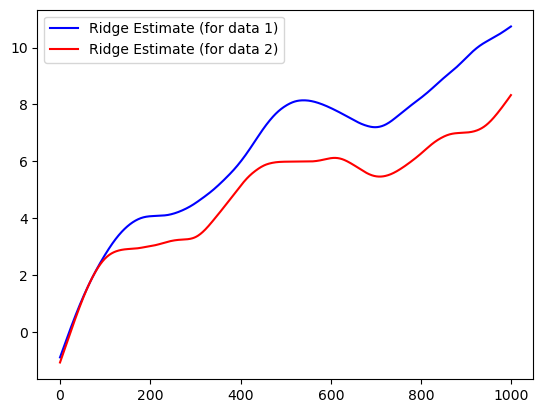

In [215]:
b_ridge_1 = solve_ridge(Xfull, y_1, lambda_val = best_lambda_1)
ridge_fitted_1 = np.dot(Xfull, b_ridge_1)

b_ridge_2 = solve_ridge(Xfull, y_2, lambda_val = best_lambda_2)
ridge_fitted_2 = np.dot(Xfull, b_ridge_2)

plt.plot(ridge_fitted_1, color = 'blue', label = 'Ridge Estimate (for data 1)')
plt.plot(ridge_fitted_2, color = 'red', label = "Ridge Estimate (for data 2)")
plt.legend()
plt.show()

In [216]:
lambda_candidates = np.array([1e1, 1e2, 1e3, 1e4])

best_lambda_1, cv_errors = lasso_cv(Xfull, y_1, lambda_candidates)
print(best_lambda_1)

best_lambda_2, cv_errors = lasso_cv(Xfull, y_2, lambda_candidates)
print(best_lambda_2)

/Users/aditya/mambaforge/envs/stat153fall2025/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1000.0
1000.0


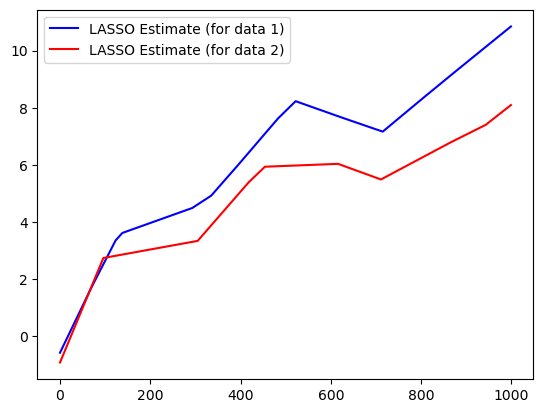

In [217]:
b_lasso_1 = solve_lasso(Xfull, y_1, lambda_val = best_lambda_1)
lasso_fitted_1 = np.dot(Xfull, b_lasso_1)

b_lasso_2 = solve_lasso(Xfull, y_2, lambda_val = best_lambda_2)
lasso_fitted_2 = np.dot(Xfull, b_lasso_2)

plt.plot(lasso_fitted_1, color = 'blue', label = 'LASSO Estimate (for data 1)')
plt.plot(lasso_fitted_2, color = 'red', label = "LASSO Estimate (for data 2)")
plt.legend()
plt.show()

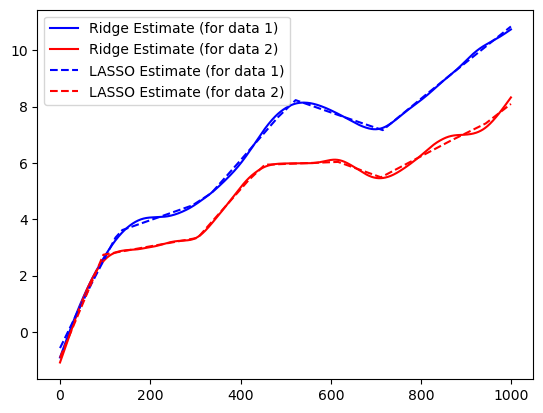

In [218]:
plt.plot(ridge_fitted_1, color = 'blue', label = 'Ridge Estimate (for data 1)')
plt.plot(ridge_fitted_2, color = 'red', label = "Ridge Estimate (for data 2)")
plt.plot(lasso_fitted_1, color = 'blue', linestyle = '--', label = 'LASSO Estimate (for data 1)')
plt.plot(lasso_fitted_2, color = 'red', linestyle = '--', label = "LASSO Estimate (for data 2)")
plt.legend()
plt.show()